In [1]:
import fitz
import matplotlib.pyplot as plt

points_table_pdf = fitz.open("C:\\Users\\tbwil\\Documents\\Projects\\IAAF_Points\\world_athletics_points_table_outdoor2022.pdf")

1351 
 - 
[1400.0, 1399.0, 1398.0, 1397.0, 1396.0, 1395.0, 1394.0, 1393.0, 1392.0, 1391.0, 1390.0, 1389.0, 1388.0, 1387.0, 1386.0, 1385.0, 1384.0, 1383.0, 1382.0, 1381.0, 1380.0, 1379.0, 1378.0, 1377.0, 1376.0, 1375.0, 1374.0, 1373.0, 1372.0, 1371.0, 1370.0, 1369.0, 1368.0, 1367.0, 1366.0, 1365.0, 1364.0, 1363.0, 1362.0, 1361.0, 1360.0, 1359.0, 1358.0, 1357.0, 1356.0, 1355.0, 1354.0, 1353.0, 1352.0]
[9.46, None, None, None, 9.47, None, None, None, 9.48, None, None, 9.49, None, None, None, 9.5, None, None, None, 9.51, None, None, 9.52, None, None, None, 9.53, None, None, None, 9.54, None, None, 9.55, None, None, None, 9.56, None, None, None, 9.57, None, None, 9.58, None, None, None, 9.59]


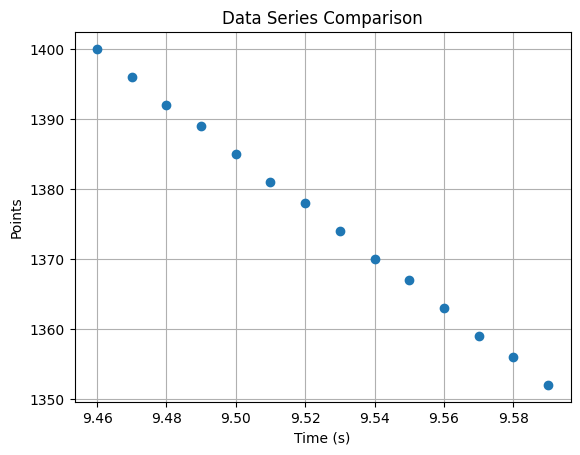

In [3]:
page = points_table_pdf[8].get_text()
rows = page.split('\n')
points = []
OM100m = []
for i in range(len(rows)):
    if((i-2)%11 == 0):
        points.append(rows[i])
    if((i-3)%11 == 0):
        OM100m.append(rows[i])
print(points[-2])
print(OM100m[-2])
points = points[1:50]
OM100m = OM100m[1:50]

points = [float(value) if (value.strip() != '-' and value.strip() != '') else None for value in points]
OM100m = [float(value) if (value.strip() != '-' and value.strip() != '') else None for value in OM100m]

print(points)
print(OM100m)

plt.plot(OM100m, points, marker='o')
plt.xlabel('Time (s)')
plt.ylabel('Points')
plt.title('Data Series Comparison')
plt.grid(True)

# Display the plot
plt.show()

In [144]:
page = points_table_pdf[98].get_text()
rows = page.split('\n')
points = []
OM100m = []
for i in range(len(rows)):
    if((i-1)%11 == 0 and i > 1):
        points.append(rows[i])
    if((i-2)%11 == 0):
        OM100m.append(rows[i])
print(points)
print(OM100m)
print(rows[13])
print(rows[13].replace(' ','').isdigit())
print(page)
# start = 0
# i = 0
# while start == 0:
#     if rows[i].replace(' ','').isdigit():
#         if int(rows[i]) == 1400:
#             start = i
#     i += 1
# print(start)

['25:15 ', ' ', '38:46 ', '1395 ', '41:46 ', '12:12 ', '52:02 ', ' - ', ' ', '38:56 ', '1384 ', '41:57 ', ' - ', '52:16 ', '25:28 ', ' ', '39:06 ', '1373 ', '42:08 ', ' - ', '52:30 ', ' - ', ' ', '39:16 ', '1362 ', '42:19 ', ' - ', '52:45 ', '25:41 ', ' ', '39:26 ', '1351 ']
[' ', '38:43 ', '1398 ', '41:43 ', ' - ', '51:58 ', '25:20 ', ' ', '38:53 ', '1387 ', '41:54 ', '12:14 ', '52:12 ', '25:26 ', ' ', '39:03 ', '1376 ', '42:05 ', ' - ', '52:26 ', '25:33 ', ' ', '39:13 ', '1365 ', '42:16 ', ' - ', '52:41 ', '25:39 ', ' ', '39:23 ', '1354 ', '42:27 ', ' - ']
38:43 
False
 MEN’S ROAD RUNNING / HOMMES COURSES SUR ROUTE 
92 
 
Points 
5km  
10km 
15km 
10 Miles 
20km 
 
1400 
12:10 
25:15 
38:43 
41:40 
51:50 
 
1399 
 - 
25:16 
38:44 
41:41 
51:52 
 
1398 
 - 
 - 
38:45 
41:42 
51:53 
 
1397 
 - 
25:17 
38:46 
41:43 
51:54 
 
1396 
12:11 
 - 
 - 
41:44 
51:56 
 
1395 
 - 
25:18 
38:47 
41:45 
51:57 
 
1394 
 - 
 - 
38:48 
41:46 
51:58 
 
1393 
 - 
25:19 
38:49 
41:47 
51:59 
 
1392 
12:1

In [30]:
points = []
num_events = 10
event_list = [[] for _ in range(num_events+1)]
event = []
for page_num in range(8,36):
    points_batch = []
    event_batch = [[] for _ in range(num_events+1)]
    page = points_table_pdf[page_num].get_text()
    rows = page.split('\n')
    page_odd = page_num % 2
    for i in range(2,len(rows)):
        if((i - 2 + page_odd) % 11 == 0):
            points_batch.append(rows[i])
        for j in range(1,num_events+1):
            if((i - 2 + page_odd) % 11 == j):
                event_batch[j].append(rows[i])
    for j in range(1,num_events+1):
        event_list[j] = event_list[j] + event_batch[j][1:51]
        # if((i - 3 + page_odd) % 11 == 0):
        #     event_batch.append(rows[i])
    points = points + points_batch[1:51]
    # event = event + event_batch[1:51]
print(points)
event_num = 10
print(event_list[event_num])

# should give the full lists. Need to check sizes to see if correct
print(len(points))
print(len(event_list[event_num]))
# print(len(event))

['1400 ', '1399 ', '1398 ', '1397 ', '1396 ', '1395 ', '1394 ', '1393 ', '1392 ', '1391 ', '1390 ', '1389 ', '1388 ', '1387 ', '1386 ', '1385 ', '1384 ', '1383 ', '1382 ', '1381 ', '1380 ', '1379 ', '1378 ', '1377 ', '1376 ', '1375 ', '1374 ', '1373 ', '1372 ', '1371 ', '1370 ', '1369 ', '1368 ', '1367 ', '1366 ', '1365 ', '1364 ', '1363 ', '1362 ', '1361 ', '1360 ', '1359 ', '1358 ', '1357 ', '1356 ', '1355 ', '1354 ', '1353 ', '1352 ', '1351 ', '1350 ', '1349 ', '1348 ', '1347 ', '1346 ', '1345 ', '1344 ', '1343 ', '1342 ', '1341 ', '1340 ', '1339 ', '1338 ', '1337 ', '1336 ', '1335 ', '1334 ', '1333 ', '1332 ', '1331 ', '1330 ', '1329 ', '1328 ', '1327 ', '1326 ', '1325 ', '1324 ', '1323 ', '1322 ', '1321 ', '1320 ', '1319 ', '1318 ', '1317 ', '1316 ', '1315 ', '1314 ', '1313 ', '1312 ', '1311 ', '1310 ', '1309 ', '1308 ', '1307 ', '1306 ', '1305 ', '1304 ', '1303 ', '1302 ', '1301 ', '1300 ', '1299 ', '1298 ', '1297 ', '1296 ', '1295 ', '1294 ', '1293 ', '1292 ', '1291 ', '1290 ', 

Plan is to extract the data from the pdf file and write it as a json so the computation only has to be done once.

In [111]:
points = []
# num_events = 6
page_start = 38
num_pages = 28
# get first page
page1 = points_table_pdf[page_start].get_text()
rows1 = page1.split('\n')
num_events = 0
start = 0
for i in range(len(rows1)):
    if rows1[i].replace(' ','').isdigit():
        if int(rows1[i]) == 1400:
            start = i
        if int(rows1[i]) == 1399:
            num_events = i - start - 1
    if num_events != 0:
        break
print(start)
print(num_events)

event_list = [[] for _ in range(num_events+1)]
event = []

# collect data
for page_num in range(page_start,page_start+num_pages):
    points_batch = []
    event_batch = [[] for _ in range(num_events+1)]
    page = points_table_pdf[page_num].get_text()
    rows = page.split('\n')
    page_odd = page_num % 2
    for i in range(2,len(rows)):
        if((i - 2 + page_odd) % (num_events+1) == 0):
            points_batch.append(rows[i])
        for j in range(1,num_events+1):
            if((i - 2 + page_odd) % (num_events+1) == j):
                event_batch[j].append(rows[i])
    for j in range(1,num_events+1):
        event_list[j] = event_list[j] + event_batch[j][1:51]
    points = points + points_batch[1:51]
print(points)
event_num = 6
print(event_list[event_num])

print(len(points))
print(len(event_list[event_num]))

13
10
['1400 ', '1399 ', '1398 ', '1397 ', '1396 ', '1395 ', '1394 ', '1393 ', '1392 ', '1391 ', '1390 ', '1389 ', '1388 ', '1387 ', '1386 ', '1385 ', '1384 ', '1383 ', '1382 ', '1381 ', '1380 ', '1379 ', '1378 ', '1377 ', '1376 ', '1375 ', '1374 ', '1373 ', '1372 ', '1371 ', '1370 ', '1369 ', '1368 ', '1367 ', '1366 ', '1365 ', '1364 ', '1363 ', '1362 ', '1361 ', '1360 ', '1359 ', '1358 ', '1357 ', '1356 ', '1355 ', '1354 ', '1353 ', '1352 ', '1351 ', '1350 ', '1349 ', '1348 ', '1347 ', '1346 ', '1345 ', '1344 ', '1343 ', '1342 ', '1341 ', '1340 ', '1339 ', '1338 ', '1337 ', '1336 ', '1335 ', '1334 ', '1333 ', '1332 ', '1331 ', '1330 ', '1329 ', '1328 ', '1327 ', '1326 ', '1325 ', '1324 ', '1323 ', '1322 ', '1321 ', '1320 ', '1319 ', '1318 ', '1317 ', '1316 ', '1315 ', '1314 ', '1313 ', '1312 ', '1311 ', '1310 ', '1309 ', '1308 ', '1307 ', '1306 ', '1305 ', '1304 ', '1303 ', '1302 ', '1301 ', '1300 ', '1299 ', '1298 ', '1297 ', '1296 ', '1295 ', '1294 ', '1293 ', '1292 ', '1291 ', '12

In [193]:
page_start = 248
num_pages = 28

def get_rows(page):
    rows = page.split('\n')
    rows = [r.strip() for r in rows if r.strip() != '']
    return rows

# get first page
page1 = points_table_pdf[page_start].get_text()
rows1 = get_rows(page1)
num_events = 0
start = 0
for i in range(len(rows1)):
    if rows1[i].replace(' ','').isdigit():
        if int(rows1[i]) == 1400:
            start = i
        if int(rows1[i]) == 1399:
            num_events = i - start - 1
    if num_events != 0:
        break
print(start)
print(num_events)

def get_start_loc(rows, page_num):
    start = 0
    for i in range(len(rows)):
        if rows[i].replace(' ','').isdigit():
            if (int(rows[i]) % 50 == 0) and (int(rows[i]) <= (1400 - 50*page_num)):
                start = i
    return start

headers = rows1[start-num_events:start]
print(headers)
event_list = [[] for _ in range(num_events+1)]
event = []

# collect data
for page_num in range(page_start,page_start+num_pages):
    points_batch = []
    event_batch = [[] for _ in range(num_events+1)]
    page = points_table_pdf[page_num].get_text()
    rows = get_rows(page)
    page_odd = page_num % 2
    start_loc = get_start_loc(rows,page_num-page_start) - num_events * page_odd
    for i in range(start_loc,len(rows)):
        for j in range(num_events+1):
            if((i - start_loc + page_odd) % (num_events+1) == j):
                event_batch[j].append(rows[i])
    for j in range(num_events+1):
        event_list[j] = event_list[j] + event_batch[j][0:50]
print(event_list[0])
event_num = 9
print(event_list[event_num])

print(len(event_list[0]))
print(len(event_list[event_num]))

12
9
['HJ', 'PV', 'LJ', 'TJ', 'SP', 'DT', 'HT', 'JT', 'Decathlon']
248 12
249 12
250 12
251 12
252 12
253 12
254 12
255 12
256 12
257 12
258 12
259 12
260 12
261 12
262 12
263 12
264 12
265 12
266 12
267 12
268 12
269 12
270 12
271 12
272 12
273 12
274 12
275 12
['1400', '1399', '1398', '1397', '1396', '1395', '1394', '1393', '1392', '1391', '1390', '1389', '1388', '1387', '1386', '1385', '1384', '1383', '1382', '1381', '1380', '1379', '1378', '1377', '1376', '1375', '1374', '1373', '1372', '1371', '1370', '1369', '1368', '1367', '1366', '1365', '1364', '1363', '1362', '1361', '1360', '1359', '1358', '1357', '1356', '1355', '1354', '1353', '1352', '1351', '1350', '1349', '1348', '1347', '1346', '1345', '1344', '1343', '1342', '1341', '1340', '1339', '1338', '1337', '1336', '1335', '1334', '1333', '1332', '1331', '1330', '1329', '1328', '1327', '1326', '1325', '1324', '1323', '1322', '1321', '1320', '1319', '1318', '1317', '1316', '1315', '1314', '1313', '1312', '1311', '1310', '1309', 

Final Copy

In [196]:
page_start = 8
num_pages = 28

def get_rows(page):
    rows = page.split('\n')
    rows = [r.strip() for r in rows if r.strip() != '']
    return rows

def get_start_loc(rows, page_num):
    start = 0
    for i in range(len(rows)):
        if rows[i].replace(' ','').isdigit():
            if (int(rows[i]) % 50 == 0) and (int(rows[i]) <= (1400 - 50*page_num)):
                start = i
    return start

def extract_event_points(page_start):
    # get first page
    page1 = points_table_pdf[page_start].get_text()
    rows1 = get_rows(page1)
    num_events = 0
    start = 0
    for i in range(len(rows1)):
        if rows1[i].isdigit():
            if int(rows1[i]) == 1400:
                start = i
            if int(rows1[i]) == 1399:
                num_events = i - start - 1
        if num_events != 0:
            break

    # get headers
    headers = rows1[start-num_events:start]
    event_list = [[] for _ in range(num_events+1)]

    # collect data
    for page_num in range(page_start,page_start+num_pages):
        event_batch = [[] for _ in range(num_events+1)]
        page = points_table_pdf[page_num].get_text()
        rows = get_rows(page)
        page_odd = page_num % 2
        start_loc = get_start_loc(rows, page_num-page_start) - num_events * page_odd
        for i in range(start_loc,len(rows)):
            for j in range(num_events+1):
                if((i - start_loc + page_odd) % (num_events+1) == j):
                    event_batch[j].append(rows[i])
        for j in range(num_events+1):
            event_list[j] = event_list[j] + event_batch[j][0:50]

    return headers, event_list

headers = []
event_scores = []

for i in range(18):
    header, event_list = extract_event_points(page_start+i*30)
    headers = headers + header
    event_scores = event_scores + event_list[1:]

for i in range(len(headers)):
    print(headers[i], len(event_scores[i]))

100m 1400
200m 1400
300m 1400
400m 1400
500m 1400
110mH 1400
400mH 1400
4x100m 1400
4x200m 1400
4x400m 1400
600m 1400
800m 1400
1000m 1400
1500m 1400
Mile 1400
2000m 1400
2000mSC 1400
3000m 1400
3000mSC 1400
2 Miles 1400
5000m 1400
10,000m 1400
5km 1400
10km 1400
15km 1400
10 Miles 1400
20km 1400
HM 1400
25km 1400
30km 1400
Marathon 1400
100km 1400
3kmW 1400
5kmW 1400
10kmW 1400
15kmW 1400
20kmW 1400
30kmW 1400
35kmW 1400
50kmW 1400
3000mW 1400
5000mW 1400
10,000mW 1400
15,000mW 1400
20,000mW 1400
30,000mW 1400
35,000mW 1400
50,000mW 1400
HJ 1400
PV 1400
LJ 1400
TJ 1400
SP 1400
DT 1400
HT 1400
JT 1400
Decathlon 1400
100m 1400
200m 1400
300m 1400
400m 1400
500m 1400
100mH 1400
400mH 1400
4x100m 1400
4x200m 1400
4x400m 1400
600m 1400
800m 1400
1000m 1400
1500m 1400
Mile 1400
2000m 1400
2000mSC 1400
3000m 1400
3000mSC 1400
2 Miles 1400
5000m 1400
10,000m 1400
5km 1400
10km 1400
15km 1400
10 Miles 1400
20km 1400
HM 1400
25km 1400
30km 1400
Marathon 1400
100km 1400
3kmW 1400
5kmW 1400
10kmW

TODO: Convert List of Lists to List of Dicts and JSON